In [1]:
import os
new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)
import socket
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pickle
from sklearn.ensemble import RandomForestRegressor
from typing import Dict, Type, Any, List, Union, Optional
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import yaml
import os
from typing import Tuple, Any, Dict, Type, Union, List
from sklearn import preprocessing

#sys.path.append('./')
from src.vae.datasets import Astro_lightcurves
from src.utils import evaluate_encoder, load_model_list, load_pp_list
from src.utils import load_yaml_priors

warnings.filterwarnings('ignore')

# Read configurations from a YAML file
with open('src/configuration/regressor.yaml', 'r') as file:
    reg_conf_file: Dict[str, Any] = yaml.safe_load(file)

# Extracting path configurations
PATH_DATA: str = reg_conf_file['PATH_DATA']
save_plots: bool = reg_conf_file['save_plots']
save_tables: bool = reg_conf_file['save_tables']


with open('src/configuration/regressor.yaml', 'r') as file:
    reg_conf_file: Dict[str, Any] = yaml.safe_load(file)

In [4]:
def process_regressors(reg_conf_file: Dict[str, Any],
                       meta_: Optional[Dict[str, Any]] = None,
                       phys2: Optional[List[str]] = None,
                       mu_: Optional[List[float]] = None,
                       samples: Optional[List[float]] = None,
                       from_vae: bool = True,
                       train_rf: bool = False, 
                       grid_search: bool = True) -> None:
    """
    Process the regressors.

    Parameters:
        reg_conf_file (Dict[str, Any]): Configuration file.
        meta_ (Dict[str, Any], optional): Metadata.
        phys2 (List[str], optional): Physical parameters.
        mu_ (List[float], optional): mu values.
        samples (List[float], optional): Sample data.
        assess_regressor (bool): Whether to assess the regressor. Default is True.
        train_rf (bool): Whether to train random forest. Default is False.

    Returns:
        None
    """

    regressors = {'RFR': RandomForestRegressor}

    config_dict = dict(reg_conf_file['regressors'])
    if from_vae:
        if (meta_ is None) or (phys2 is None) or (mu_ is None):
            raise ValueError("Meta data, phys2, and mu_ must be provided if assess_regressor is True.")
        p = meta_[phys2].copy()
        z = mu_.copy()
    else:
        if samples is None:
            raise ValueError("Samples must be provided if assess_regressor is False.")
        p = samples
    
    for name, reg in regressors.items():
        filename = 'models/' + reg_conf_file['model_parameters']['ID']+'_'+name + '.pkl'
        if train_rf:
            print(f"Training new model {name}")
            if grid_search:
                print('Aplying grid search.') 
                model, _ = train_rf_with_gs(p, z)
            else:
                print('Grid seacrh was not applied')
                model = train_model(reg, config_dict, name, p, z)
            save_model(model, filename=filename)
            z_hat = model.predict(p)
            print_metrics_regression(z, z_hat)
            plot_figures(z, z_hat)
        else:
            print(f"Loading existing model from {filename}")
            model = pickle.load(open(filename, 'rb'))
            print('Getting predictions')
            z_hat = model.predict(p)
    return z_hat


# Function to set up environment and download model weights if not available
def setup_environment(ID: str, gpu: bool = False) -> Tuple[Any, Dict[str, Any], torch.device]:
    device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")
    vae, config = load_model_list(ID=ID)
    return vae, config, device

# Function to prepare the dataset
def prepare_dataset(config: Dict[str, Any]) -> Astro_lightcurves:
    dataset = Astro_lightcurves(survey=config['data'],
                            band='I' if config['data'] else 'B',
                            use_time=True,
                            use_err=True,
                            norm=config['normed'],
                            folded=config['folded'],
                            machine=socket.gethostname(),
                            seq_len=config['sequence_lenght'],
                            phy_params=config['phys_params'])
    if config['classes'].split('_')[0] == 'drop':
        dataset.drop_class(config['classes'].split('_')[1])
    elif config['classes'].split('_')[0] == 'only':
        dataset.only_class(config['classes'].split('_')[1])
    dataset.remove_nan()

    return dataset

# Function to print regression metrics
def print_metrics_regression(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    print('Mean Squared Error (MSE): ', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error (RMSE): ', sqrt(mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error (MAE): ', mean_absolute_error(y_test, y_pred))
    print('R^2 Score: ', r2_score(y_test, y_pred))

# Functions to plot various diagnostic plots
def scatter_plot(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    plt.scatter(y_test, y_pred, alpha=reg_conf_file['plotting']['scatter_plot_alpha'])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=reg_conf_file['plotting']['scatter_plot_line_width'])
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('True vs Predicted Values')
    plt.savefig('scatter_plot.png')
    plt.show()

def residual_plot(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=reg_conf_file['plotting']['residual_plot_alpha'])
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='k', linestyles='solid')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.savefig('residual_plot.png')
    plt.show()

def prediction_error_plot(y_test: np.ndarray, y_pred: np.ndarray) -> None:

    residuals = y_test - y_pred
    sns.distplot(residuals)
    plt.title('Prediction Error Plot')
    plt.xlabel('Prediction Error')
    plt.savefig('prediction_error.png')
    plt.show()

def plot_figures(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    scatter_plot(y_test, y_pred)
    residual_plot(y_test, y_pred)
    prediction_error_plot(y_test, y_pred)

# Function to load predictions from a saved model
def load_predict(pp: np.ndarray, filename: str = 'file.pkl') -> np.ndarray: 
    loaded_model = pickle.load(open(filename, 'rb'))
    z = loaded_model.predict(pp)
    return z

# Function to save trained model to disk
def save_model(model: Any, filename: str = 'filename_model.pkl') -> None:
    pickle.dump(model, open(filename, 'wb'))

# Function to train the model using specified configurations
def train_model(reg: Type, config_dic: Dict[str, Any], name: str, p: np.ndarray, z: np.ndarray, test_size=0.1) -> Any:
    model = reg(**config_dic[name])
    try:
        print('p: ', p.shape)
        print('z: ', z.shape)
        print('Using {} to test'.format(test_size))
        print(p)
        print(z)
        if test_size>0:
            p_train, p_test, z_train, z_test = train_test_split(p, z, test_size=test_size, random_state=42)
            model.fit(p_train, z_train)
            z_pred = model.predict(p_test)
            print_metrics_regression(z_test, z_pred)
        else:
            print('Fitting model') 
            model.fit(p, z)
            print('Predicting latent space')
            z_pred = model.predict(p)
            print('getting metrics')
            print_metrics_regression(z, z_pred)
    except MemoryError:
        print('Fail') 
    return model

def apply_regression(vae_model, samples: Union[np.ndarray, List] = None,  from_vae: bool = False, 
        train_rf: bool = True, 
        phys2 = ['abs_Gmag', 'teff_val', 'Period', 'radius_val', '[Fe/H]_J95']) -> None:

    if from_vae:
        print('training regressor using vae latent space')
        gpu = reg_conf_file['model_parameters']['gpu'] #True 
        print('vae model: ', vae_model)
        vae, config, _ = setup_environment(vae_model, gpu)
        dataset = prepare_dataset(config)
        train_dataloader, _ = dataset.get_dataloader(batch_size=100, test_split=0.0, shuffle=False)
        mu, _ = evaluate_encoder(vae, train_dataloader, config, force=False)
        meta_ = dataset.meta.dropna(subset=phys2)
        mu_ = mu.iloc[:, :-1].values
        mu_ = mu_.astype(np.float64)
        print('meta: ', meta_.shape)
        print('mu: ', mu_.shape)
        unique_idx = meta_.reset_index().drop_duplicates(subset=['OGLE_id']).index
        meta_ = meta_.iloc[unique_idx]
        mu_ = mu_[unique_idx]
        print('after dropping duplicated objects')
        print('meta: ', meta_.shape)
        print('mu: ', mu_.shape)
        z_hat = process_regressors(reg_conf_file, phys2=dataset.phy_names, meta_= meta_, mu_=mu_,
                                  samples= None, from_vae=from_vae, 
                                  train_rf=True, grid_search=False)
    else: 
        z_hat = process_regressors(reg_conf_file=reg_conf_file, meta_=None,
                                phys2=phys2, mu_=None, samples=samples, 
                                from_vae=from_vae, train_rf=False, grid_search=False)
    return z_hat
        

training regressor using vae latent space
vae model:  3iyiphkn
##################################################
LOADING cVAE: 
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3iyiphkn/VAE_model_light-breeze-224.pt
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_LOG_6PP.npy.gz
phy_params:  PTARMG
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
Evaluating Encoder...
Elapsed time  : 15.00 s
########################################
meta:  (40074, 8)
mu:  (40074, 6)
after dropping duplicated objects
meta:  (19245, 8)
mu:  (19245, 6)
Training new model RFR
Grid seacrh was not applied
p:  (19245, 6)
z:  (19245, 6)
Using 0.1 to test
         Period  teff_val  [Fe/H]_J95  abs_Gmag  radius_val    logg
0     -0.041242  3.785559     -4.0969    5.1693 

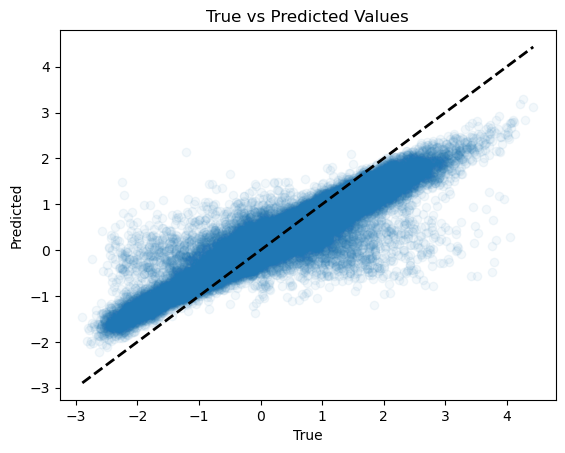

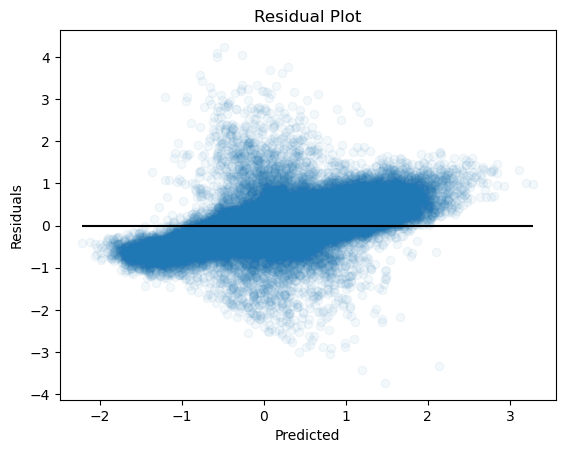

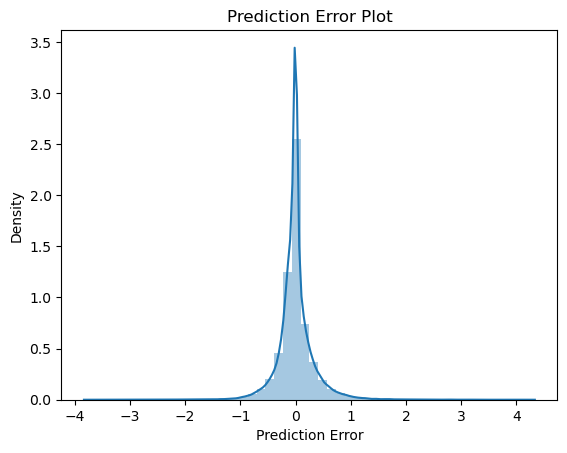

array([[-1.31426581e+00,  2.34032962e-01, -4.64161841e-03,
        -9.45038556e-02, -6.32053643e-03, -2.15186480e-01],
       [-1.07204942e+00,  7.55423164e-01, -6.51557409e-03,
        -1.52055337e-01,  3.85548442e-01, -2.95485233e-01],
       [ 8.37737877e-02, -1.61082880e-02, -4.20227806e-04,
         7.16412151e-02, -5.63381016e-02,  1.74041026e-02],
       ...,
       [ 6.83529807e-02,  6.40255547e-02, -1.94240327e-03,
        -4.36873455e-02, -1.62453797e-01,  9.96715369e-01],
       [ 2.37798037e-01,  1.01131963e+00, -3.62071269e-03,
         4.21675598e-01,  4.99803592e-01, -4.80145732e-02],
       [ 8.32704076e-01,  1.82199078e-01, -2.22096974e-03,
         3.34801055e-01, -1.07722048e-01,  1.33177875e-01]])

In [5]:
vae_model =   reg_conf_file['model_parameters']['ID']   
PP_list = load_pp_list(vae_model)

apply_regression(vae_model, from_vae = True, 
        train_rf = True, 
        phys2 = ['abs_Gmag', 'teff_val', 'Period', 'radius_val', '[Fe/H]_J95'])